# Spaceship Titanic usando Floresta Aleatória

Nesse notebook, vamos fazer uma análise exploratória dos dados presentes no dataset Spaceship Titanic. Depois, vamos treinar um modelo de Floresta Aleatória para prever quais passageiros foram transportados para outra dimensão pela anomalia. Os dados foram retirados do [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data).

Aqui será mostrada a solução mais simples e rápida para obtermos um arquivo para ser submetido no Kaggle.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
import logging
logging.disable(sys.maxsize)

### Carregando os dados

In [93]:
import os
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [94]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [95]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


A primeira etapa na análise exploratória será definir os tipos de dados de cada coluna, e se são relevantes para uma análise preditiva.

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [97]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Análise exploratória

Nós temos variáveis relevantes numéricas, booleanas e categóricas. A próxima etapa é verificar como as variáveis se comportam em relação à variável alvo.

Primeiramente vamos elaborar histogramas para avaliar a distribuição dos dados numéricos.

In [98]:
# separar apenas os dados numéricos
train_num = train.select_dtypes(include=['int64', 'float64'])
train_num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


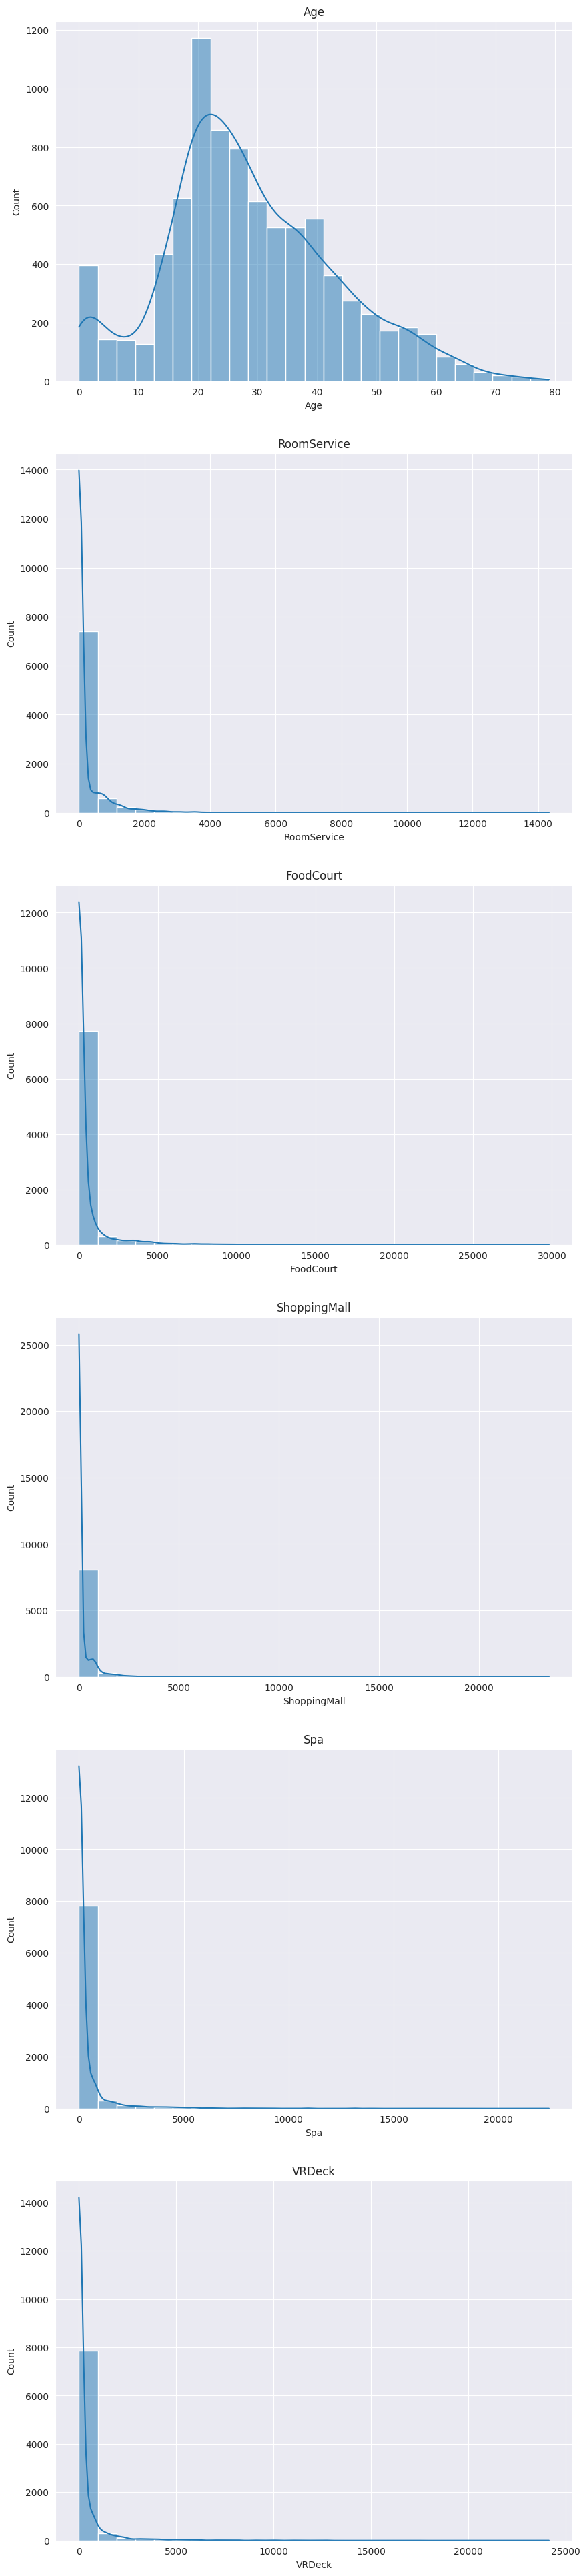

In [102]:
fig, ax = plt.subplots(6, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_num.columns):
    try:
        sns.histplot(train_num[col], ax=ax[i], bins=25, kde=True)
        ax[i].set_title(col)
    except:
        pass

Em seguida, vamos verificar o comportamento dessas variáveis numéricas em relação à variável alvo. Para isso, vamos usar um histograma sobreposto.

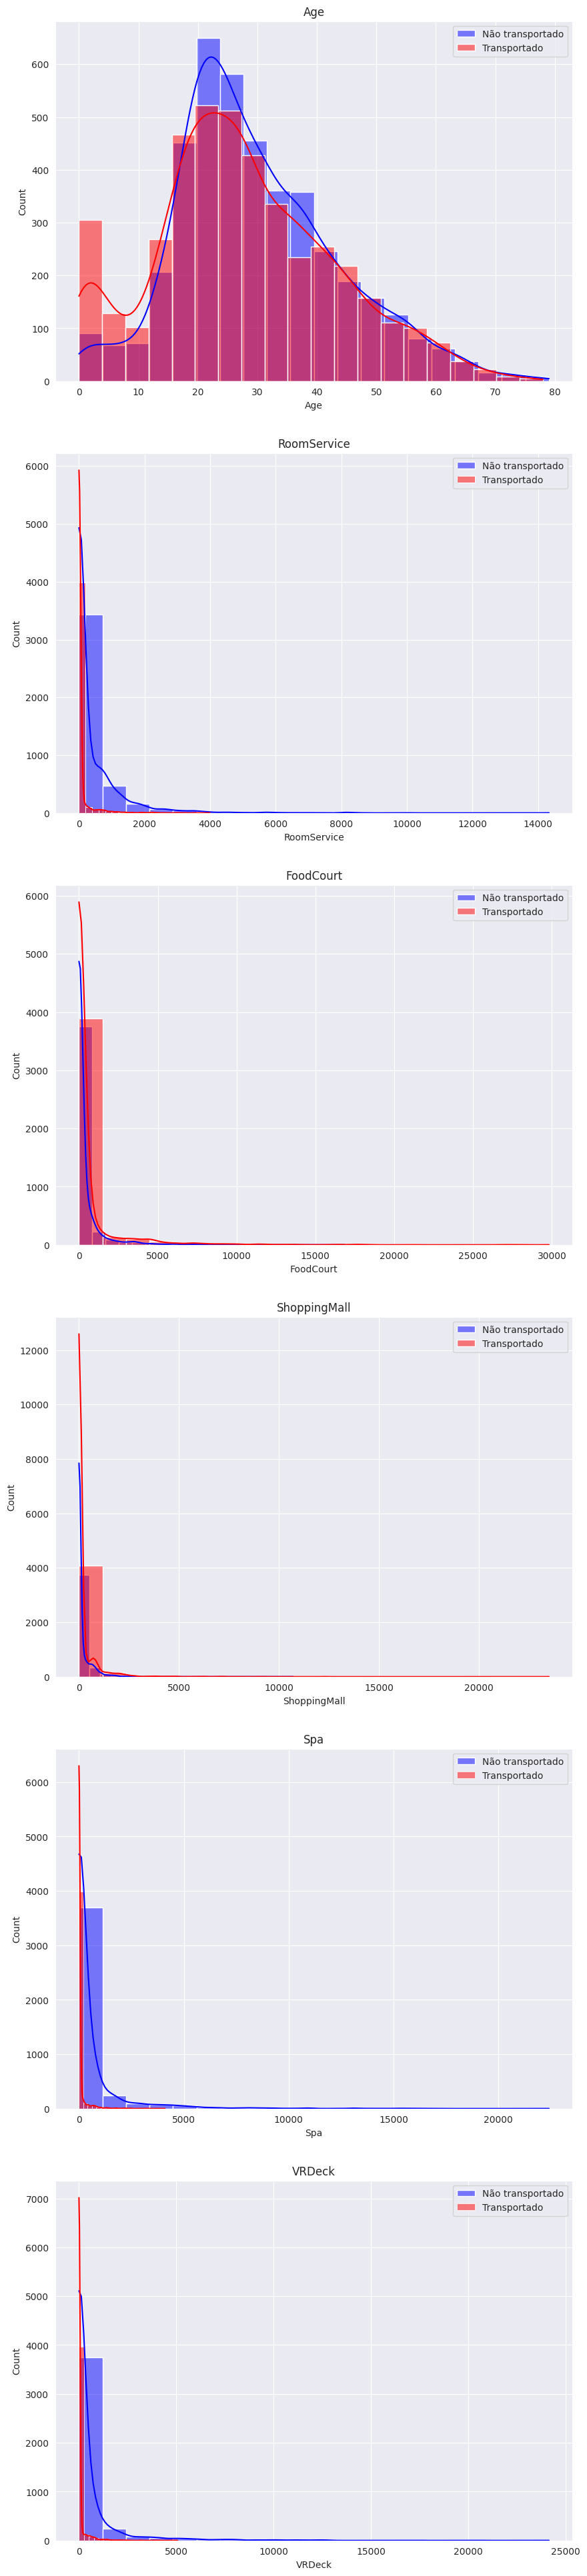

In [103]:
train_num['Transported'] = train['Transported']

fig, ax = plt.subplots(6, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_num.columns):
    try:
        sns.histplot(train_num[train_num['Transported'] == 0][col], ax=ax[i], bins=20, kde=True, color='blue', label='Não transportado')
        sns.histplot(train_num[train_num['Transported'] == 1][col], ax=ax[i], bins=20, kde=True, color='red', label='Transportado')
        ax[i].set_title(col)
        ax[i].legend()
    except:
        pass

Agora vamos verificar a relação entre as variáveis categóricas e a variável alvo. Para isso, vamos usar um gráfico de barras.

In [47]:
train_cat = train.select_dtypes(include=['object', 'bool'])
train_cat.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True


Entre as variáveis categóricas, temos algumas que aparentemente não são relevantes para a análise, como por exemplo o nome do passageiro, o seu número de identificação e o número da cabine. Vamos removê-las do dataframe para facilitar a construção das figuras.

In [105]:
try:
    train_cat = train_cat.drop(['Name', 'PassengerId', 'Cabin'], axis=1)
except:
    pass

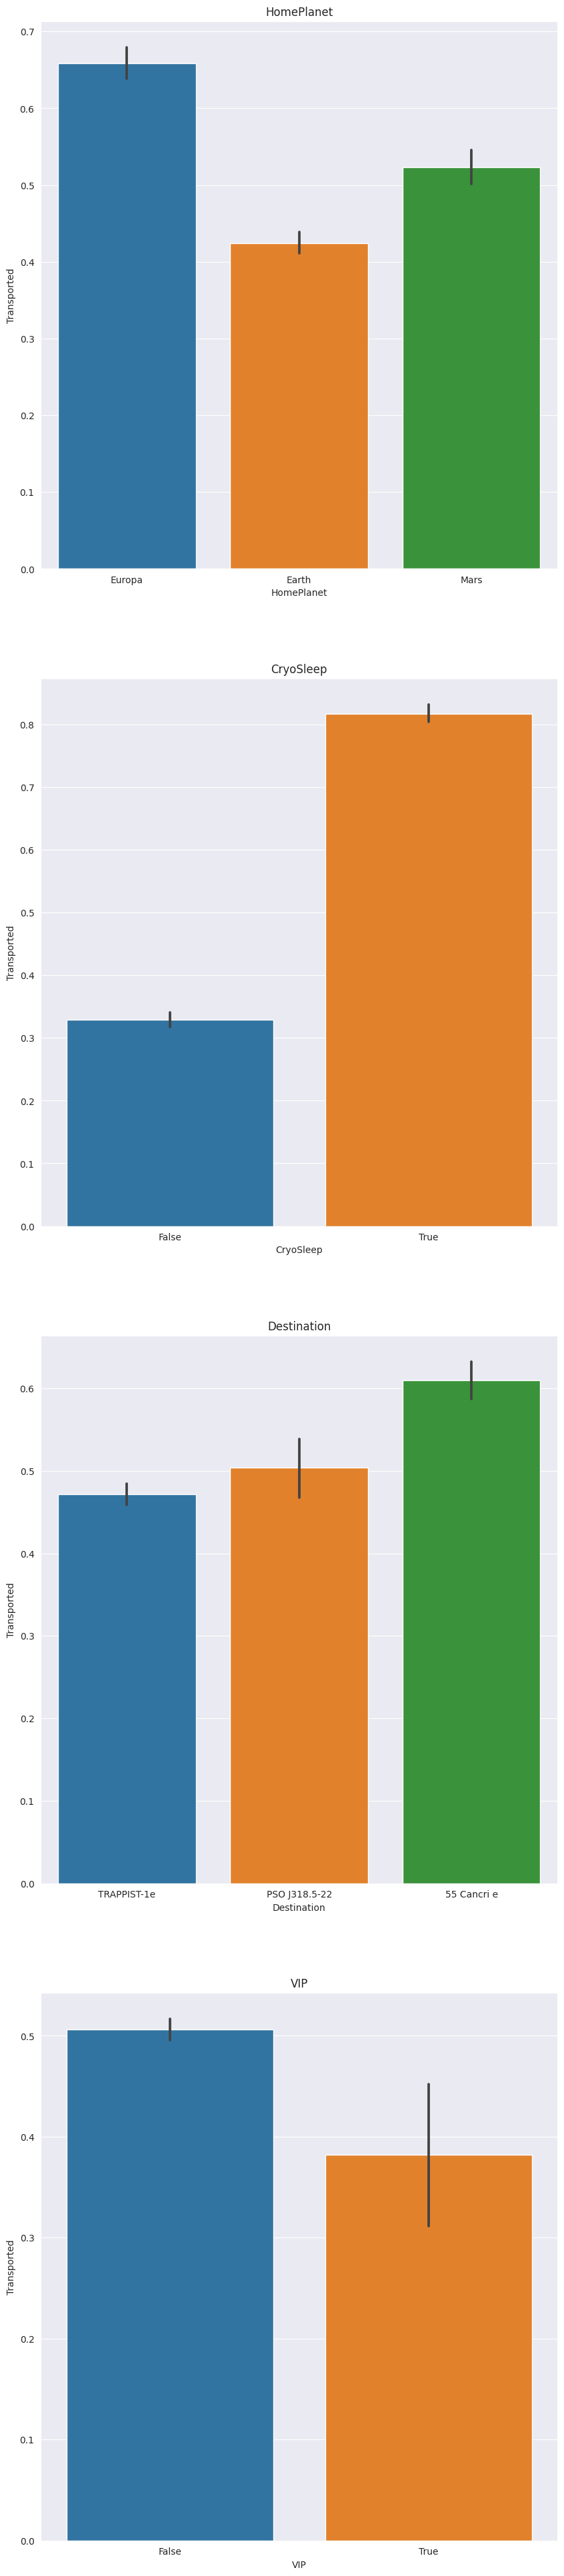

In [107]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_cat.columns):
    try:
        sns.barplot(x=train_cat[col], y=train_cat['Transported'], ax=ax[i])
        ax[i].set_title(col)
    except:
        pass

A partir dos gráficos elaborados é possível obter uma boa base de quais são as variáveis mais relevantes para a análise. Vamos agora verificar a correlação entre as variáveis numéricas.

In [108]:
corr = train_num.corr()
corr

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


<Axes: >

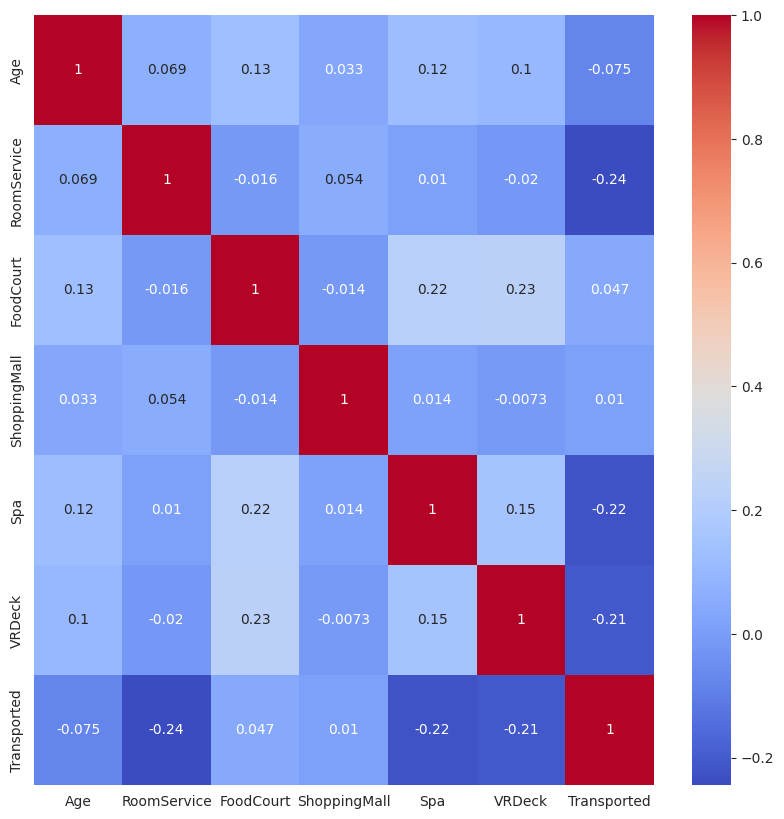

In [109]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

O heatmap de correlação também pode nos auxiliar a verificar quais variáveis podem ser consideradas mais importantes para a predição, se tratando de variáveis numéricas. A maior parte das correlações apresentadas é fraca quando se trata da variável alvo.

### Pré-processamento dos dados

Agora que já temos uma boa base de como os dados estão distribuídos, vamos prepará-los para serem utilizados no modelo de aprendizado de máquina. Primeiramente, vamos remover as variáveis que não serão utilizadas na análise. Nesse caso, vamos utilizar todas as variáveis numéricas, e as variáveis categóricas selecionadas, excluindo as que acreditamos ser irrelevantes para a análise.

In [110]:
if 'Name' in train.columns:
    train = train.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [111]:
if 'Name' in test.columns:
    test = test.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [112]:
y = train['Transported']
X = train.drop('Transported', axis=1)

Como algumas variáveis categóricas não são binárias, vamos precisar utilizar variáveis dummy para representá-las.

Para resumir, variáveis categóricas são variáveis que têm valores que correspondem a categorias ou grupos específicos. Elas podem ser divididas em duas categorias: nominais e ordinais. As variáveis nominais não têm uma ordem ou hierarquia natural, enquanto as variáveis ordinais têm uma ordem natural ou hierarquia.

Ao treinar um modelo de machine learning, é importante transformar variáveis dummy em variáveis categóricas para que o modelo possa entender e interpretar corretamente as informações presentes nos dados. As variáveis dummy são criadas a partir de variáveis categóricas, com o objetivo de converter essas variáveis em um formato numérico que possa ser utilizado pelos modelos de machine learning.

Ao converter variáveis dummy em variáveis categóricas, o modelo pode entender melhor as relações entre as diferentes categorias e levar em consideração a hierarquia natural, se houver. Além disso, essa transformação permite que o modelo trate as diferentes categorias de forma equivalente, sem atribuir pesos ou importâncias diferentes a cada categoria.

Portanto, a transformação de variáveis dummy em variáveis categóricas é essencial para a preparação dos dados antes do treinamento do modelo de machine learning, garantindo que o modelo possa entender e interpretar corretamente as informações presentes nos dados categóricos.

Para realizar a transformação de variáveis dummy em variáveis categóricas, vamos utilizar a função `pd.get_dummies()`. Essa função cria uma nova coluna para cada categoria presente na variável categórica, e atribui o valor 1 para a categoria correspondente, e 0 para as demais categorias.

In [113]:
X.VIP = X.VIP.astype(bool)
test.VIP = test.VIP.astype(bool)

In [114]:
X = pd.get_dummies(X)
test = pd.get_dummies(test)
X.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,False,False,True
1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,False,True,False,False,False,True
2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,False,True,False,False,False,True
3,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,False,True,False,False,False,True
4,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,False,True,False,False,False,True


In [115]:
X = X.fillna(0)
test = test.fillna(0)
y = y.fillna(0)

Agora, transformamos todas as variáveis categóricas em binárias com a função `get_dummies()`, separamos os datasets em treinamento e teste, removemos os nulos (`fillna`), e separamos a variável resposta do dataset a ser utilizado para treinar. Podemos prosseguir com o treinamento do modelo.

### Treinamento do modelo: árvore de decisão

Para o problema em questão, vamos utilizar um classificador de árvore de decisão. Para isso, vamos utilizar a biblioteca `scikit-learn`, que é uma das bibliotecas mais utilizadas para machine learning em Python.

Um algoritmo de árvore de decisão é uma técnica de aprendizado de máquina supervisionado que permite a construção de um modelo preditivo que faz previsões ou decisões com base em regras ou condições simples.

O algoritmo começa com um conjunto de dados de treinamento que é dividido em subconjuntos menores com base em critérios como entropia ou impureza de Gini. Essa divisão é feita com o objetivo de separar os dados em grupos homogêneos, nos quais as amostras têm características semelhantes.

A entropia é uma medida de incerteza ou desordem em um conjunto de dados. Quanto maior a entropia, mais incerta é a classificação dos dados. A entropia é calculada pela fórmula:

$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$

onde $S$ é o conjunto de dados, $c$ é o número de classes, e $p_i$ é a proporção de exemplos na classe $i$.

O índice de Gini é outra medida de impureza que é usada em árvores de decisão. O índice de Gini mede a probabilidade de classificação incorreta de um exemplo aleatório, escolhido aleatoriamente da população. Quanto maior o índice de Gini, maior a impureza do conjunto de dados. O índice de Gini é calculado pela fórmula:

$G(S) = 1 - \sum_{i=1}^{c} p_i^2$

onde $S$ é o conjunto de dados, $c$ é o número de classes, e $p_i$ é a proporção de exemplos na classe $i$.

A partir daí, é criada uma árvore de decisão, que é uma estrutura hierárquica de decisões. Cada nó na árvore representa uma decisão ou um teste em uma característica específica, e cada ramo representa uma possível resposta ou resultado. Os ramos subsequentes continuam a se ramificar com base em novos testes e características até que um nó de folha seja alcançado. Esse nó de folha representa a decisão final ou a previsão para uma determinada amostra.

Durante a construção da árvore, é importante escolher a melhor característica para dividir os dados em cada etapa. Isso é feito por meio de cálculos de impureza ou ganho de informação para avaliar a relevância de cada característica em relação à variável de saída.

Uma vez construída a árvore de decisão, o modelo pode ser usado para fazer previsões em dados não vistos. Para cada nova amostra, a árvore é percorrida seguindo o caminho correspondente aos testes nas características da amostra, até que se chegue a um nó de folha, que representa a decisão final ou a previsão para essa amostra.

Os algoritmos de árvore de decisão são amplamente utilizados em problemas de classificação e regressão em diferentes áreas, como finanças, saúde, marketing, entre outras. Eles são conhecidos por sua interpretabilidade e facilidade de visualização, permitindo que os usuários entendam facilmente como as decisões são tomadas pelo modelo.

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=3)

model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

Com o modelo treinado, é possível renderizá-lo. Isso permite que o modelo seja visualizado e entendido de forma mais fácil e intuitiva. Para isso, vamos utilizar a biblioteca `pydotplus`, que permite a renderização de árvores de decisão em Python.

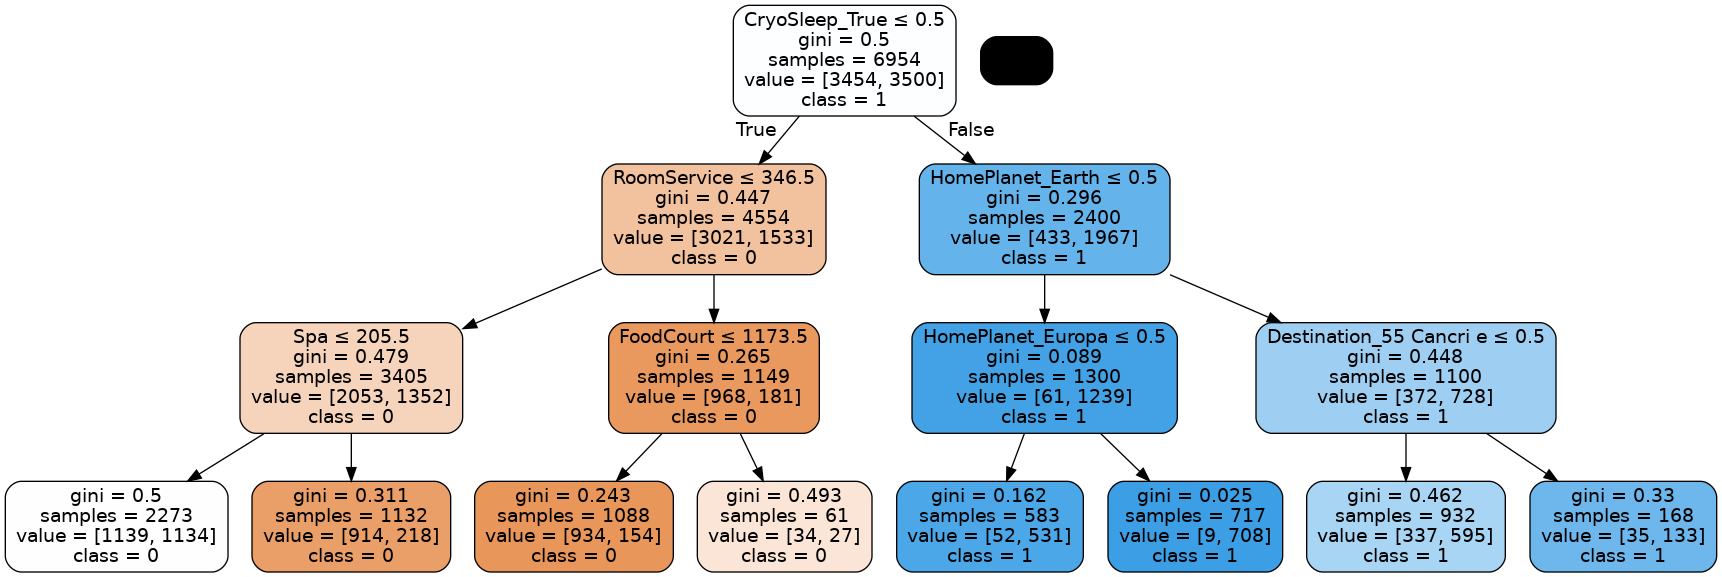

In [117]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

A árvore pode ser interpretada facilmente seguindo o caminho da raiz até as folhas. Cada nó representa uma decisão ou teste em uma característica específica, e cada ramo representa uma possível resposta ou resultado. Os ramos subsequentes continuam a se ramificar com base em novos testes e características até que um nó de folha seja alcançado. Esse nó de folha representa a decisão final ou a previsão para uma determinada amostra.

O primeiro nó, por exemplo, representa a decisão se a pessoa está em `CryoSleep` ou não. O modelo também mostra o índice de Gini em cada nó, que já foi explicado anteriormente. `value` representa a quantidade de amostras em cada classe, e `class` representa a classe predita para cada nó.

Com o modelo pronto e treinado, vamos testá-lo. Antes de treinar, dividimos o dataset aleatoriamente entre treinamento e teste. Agora, vamos utilizar o teste para verificar a acurácia do modelo, além de definir sua matriz de confusão, que representa quantos dados foram corretamente classificados, e quantos foram classificados incorretamente.

In [118]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7222541690626797

In [119]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[740, 121],
       [362, 516]])

Todos esses dados estão resumidos no `classification_report()`, que mostra a precisão, recall, f1-score e suporte para cada classe. O suporte é o número de ocorrências de cada classe no dataset de teste. Para mais informações sobre essas métricas, consulte o artigo em [Statology](https://www.statology.org/sklearn-classification-report/).

In [120]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.86      0.75       861
        True       0.81      0.59      0.68       878

    accuracy                           0.72      1739
   macro avg       0.74      0.72      0.72      1739
weighted avg       0.74      0.72      0.72      1739



Resumindo os dados acima, a precisão da previsão para os dados foi de 67% para quando o passageiro não foi transportado, e 81% para quando o passageiro foi transportado.